# 18HEUR - GA for training ANN

### Miroslav Kubů

kubumiro@fjfi.cvut.cz

In [1]:
#import GA 
#import AN 

import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

Jako trénovací data používáme pozorování z IRIS datasetu pro dvě třídy pozorování, jež jsou uloženy v prvních 100 pozorováních. Skrze ANN tedy chceme provádět úlohu statistické klasifiakce.

In [2]:
iris = datasets.load_iris()
X= iris.data[:100, :] #input
Y = iris.target[:100] #target

In [3]:
Y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1])

# AN.py

V této části popíšeme strukturu souboru AN.py, ve kterém je implementován model pro predikci výstupu ANN.

In [4]:
import numpy as np

Pro výpočty v rámci ANN definujeme aktivační funkce. V našem případě budeme jakožto aktivační funkci skrytých vrtev používat funkci

\begin{equation}
    \textrm{ReLU} (x) = \begin{cases}
    x &\mbox{pokud } x \geq 0 \\
    0 & \mbox{pokud } x <  0 \end{cases}.
\end{equation}

Aktivační funkce pro výstupní neuron je s ohledem na úlohu klasifikace funkce sigmoid definovaná jako 

\begin{equation}
f(x) = \frac{1}{1+e^{-x}}.
\end{equation}

Její výstup lze poté interpetovat jako pravděpodobnost příslušností k třídě.

In [4]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-1 * x))

def relu(x):
    result = x
    result[x < 0] = 0
    return result

V rámci této funkce počítáme výstup ANN při zadaných vahách a vstupu. Kromě predikce je výstupem funkce též accuracy (ACC) vypočtená na základě poměru správně klasifikovaných pozorování oproti celkového počtu.

\begin{equation}
    ACC = \frac{\#\textrm{correctly predicted}}{\#\textrm{total}}.
\end{equation}

Principem této funkce je maticově pronásobit vstupní pozorování napříč vrstvami a výstupy maticového násobení vždy transformovat skrze ReLU a v poslední vrstvě poté použít sigmoidální funkci. Na konci poté vypočteme predicted_label jakožto třídu s maximální pravděpodobností.

In [5]:
def predict_outputs(weights_mat, inputs, outputs, activation="relu"):
    Y_pred = np.zeros(shape=(inputs.shape[0]))
    Y_prob = np.zeros(shape=(inputs.shape[0]))
    for i in range(inputs.shape[0]):
        x = inputs[i, :]
        for curr_weights in weights_mat:
            x = np.matmul(a=x, b=curr_weights)
            if activation == "relu":
                x = relu(x)
            elif activation == "sigmoid":
                x = sigmoid(x)
      
    #output of sigmoid function > 0.5 ---> input is considered as class 1 with prob. > 0.5
    
        if x>0.5: 
            predicted_label =1
        else:
            predicted_label=0
        Y_prob[i] = x
        Y_pred[i] = predicted_label
    correct = np.where(Y_pred == outputs)[0].size
    accuracy = (correct / outputs.size) * 100
    return accuracy, Y_pred, Y_prob

Funkce 'predict_outputs' tak vrací celkovou accuracy modelu a jeho predikované výstupy.

# GA.py

V následujících blocích popíšeme funkce pro výpočet genetického algoritmu implementované v souboru GA.py.

In [6]:
import numpy as np
import random

V rámci výpočtu predikce v ANN využíváme maticové násobení vstupu $x \in \mathbb{R}^d$ s maticí vah $W\in \mathbb{R}^{d,p}$. Procesy v rámci GA bude nicméně jednodušší provádět s populací reprezentovanou vektorem parametrů. Právě proto definujeme funkce transformující naší matici parametrů $W\in \mathbb{R}^{d,p}$ do vektoru $w\in \mathbb{R}^{d \times p}$. Ten posléže použijeme ve funkcích GA, a poté zpětně převedeme do matice použitelné v ANN.

In [7]:
def mat_to_vector(matrix_weights):
    weights_vector = []
    for i in range(matrix_weights.shape[0]):
        curr_vector = []
        for layer_i in range(matrix_weights.shape[1]):
            vector_weights = np.reshape(matrix_weights[i, layer_i], newshape=(matrix_weights[i, layer_i].size))
            curr_vector.extend(vector_weights)
        weights_vector.append(curr_vector)
    return np.array(weights_vector)

def vector_to_mat(vector_weights, matrix_weights):
    mat_weights = []
    for i in range(matrix_weights.shape[0]):
        start = 0
        end = 0
        for layer_i in range(matrix_weights.shape[1]):
            end = end + matrix_weights[i, layer_i].size
            curr_vector = vector_weights[i, start:end]
            mat_layer_weights = np.reshape(curr_vector, newshape=(matrix_weights[i, layer_i].shape))
            mat_weights.append(mat_layer_weights)
            start = end
    return np.reshape(mat_weights, newshape=matrix_weights.shape)

Pro účely GA používáme fitness funkci, která slouží jako kritérium kvality pro jednotlivé populace. V našem případě pro účely klasifikace volíme jakožto fitness function tzv. accuracy, kterou definujeme jako

\begin{equation}
    ACC = \frac{\#\textrm{correctly predicted}}{\#\textrm{total}}.
\end{equation}

K jejímu výpočtu tedy použijeme výše popsanou funkci `predict_outputs`.

In [8]:
def fitness_pop(weights_matrix, inputs, outputs, activation="relu"):
    accuracy = np.empty(shape=(weights_matrix.shape[0]))
    for i in range(weights_matrix.shape[0]):
        pom_mat = weights_matrix[i, :]
        accuracy[i], _ , _ = predict_outputs(pom_mat, inputs, outputs, activation=activation)
    return accuracy

Na základě velikosti hodnot fitness function vybíráme zástupce pro crossover. Funkce `select_mating_pool` tak z populace vybere na základě fitness celkově `num_parents` rodičů pro křížení. Vybíráme vždy rodiče s největší fitness.

In [9]:
def select_mating_pool(pop, fitness, num_parents):
    parents = np.empty((num_parents, pop.shape[1]))
    for parent_i in range(num_parents):
        max_fitness_i = np.where(fitness == np.max(fitness))
        max_fitness_i = max_fitness_i[0][0]
        parents[parent_i, :] = pop[max_fitness_i, :]
        fitness[max_fitness_i] = -1 # so that we won't use this parent again
    return parents

Funkce `crossover` provádí křížení vybraných rodičů `parents`. Vstup `offspring_size` odpovídá počtu potomků a `cross_percent` $\in (0,100)$ poté crossover point mezi dvěma rodiči. Z mating pool tedy vybereme dva rodiče `parent1` a `parent2`, a jejich potomka `offspring` z nich poté vytvoříme na základě poměru `cross_percent`.

In [10]:
def crossover(parents, offspring_size,cross_percent):
    offspring = np.empty(offspring_size)
    crossover_point = np.uint8(offspring_size[1]*cross_percent/100)
    for k in range(offspring_size[0]):
        
        #using modulo, we choose a sequence of parents to mate
        parent1_i = k%parents.shape[0] #first parent to mate
        parent2_i = (k+1)%parents.shape[0] #second parent to mate.
        
        offspring[k, 0:crossover_point] = parents[parent1_i, 0:crossover_point] 
        offspring[k, crossover_point:] = parents[parent2_i, crossover_point:] # ]rest of the genes is taken from the 2nd parent
        
    return offspring

V rámci funkce `mutation` mutujeme geny potomků `offspring_mutation` u (`mutation_percent`)% chromosomů. Mutaci přitom provádíme přičtením náhodného čísla z uniformního rozdělení $U(-1,1)$ k náhodně vybraným genům.

In [11]:
def mutation(offspring_mutation, mutation_percent):
    #numb. of chromosomes mutated
    num_mutations = np.uint8((mutation_percent*offspring_mutation.shape[1])/100) 
    
    # randomly selected indices for offspring mutation.
    mutation_indices = np.array(random.sample(range(0, offspring_mutation.shape[1]), num_mutations))
    
    # mutation changes a single gene in each offspring randomly.
    for i in range(offspring_mutation.shape[0]):
        rand_numb = np.random.uniform(-1.0, 1.0, 1) # random number to be added to the gene.
        offspring_mutation[i, mutation_indices] = offspring_mutation[i, mutation_indices] + rand_numb
    return offspring_mutation

# Main file

### Genetic algorithm parameters:

V tomto kroku uživatel volí základní parametry pro GA. 

1.    Počet parents v mating pool
2.    Počet generací
3.    Procento mutace
4.    Poměr rozdělení genů pro crossover
5.    Počet řešení pro jednu populaci

In [19]:
num_parents_mating = 4
num_generations = 500
mutation_percent = 10
cross_percent = 60
sol_per_pop = 10

### Architektura ANN

1. layer 1 ... 150 neurons
2. layer 2 ... 60 neurons
3. output layer ... 1 output neuron

Při inicializaci vah na nuly provádí ANN pouze náhodnou klasifikaci. Váhy ANN proto inicializujeme z uniformního rozdělení z intervalu (-0.1,0.1), tj.


\begin{equation}
w \sim U(-0.1,0.1).
\end{equation}

V následujícím kroku tedy nastavíme počáteční váhy pro jednotlivé vrstvy. V řeči GA tak budujeme první generaci.

In [20]:
initial_pop_weights = []
data_inputs=X
data_outputs=Y


for solution in np.arange(0, sol_per_pop):
    HL1_neurons = 10 #neurons in 1st hidden layer
    input_HL1_weights = np.random.uniform(low=-0.1, high=0.1, size=(data_inputs.shape[1], HL1_neurons))

    HL2_neurons = 10 #neurons in 2nd hidden layer
    HL1_HL2_weights = np.random.uniform(low=-0.1, high=0.1, size=(HL1_neurons, HL2_neurons))

    output_neurons = 1 #neurons in the output layer
    HL2_output_weights = np.random.uniform(low=-0.1, high=0.1, size=(HL2_neurons, output_neurons))

    initial_pop_weights.append(np.array([input_HL1_weights, HL1_HL2_weights, HL2_output_weights]))

### Main algorithm

V hlavním kroku přes každou generaci provádím následující akce

1. evaluate fitness - napočítáme fitness == accuracy modelu s aktualnimi vahami
2. select mating pool - na základě fitness vybíráme parents pro crossover  
3. do the crossover - vytváříme novou generaci
4. perform mutation - do nové generace vnášíme prvky mutace

Zatímco v rámci ANN počítáme s maticovým násobením pomocí matic vah, v rámci výpočtů pro populace v GA používáme vektory. Z tohoto důvodu v algoritmu opakovaně používáme funkce `mat_to_vector` a `vector_to_mat`, které převádějí naše matice vah na vektor a naopak. Každé jednotlivé řešení poté obsahuje všechny váhy z modelu, v každé generaci přitom kalkulujeme s počtem `sol_per_pop` řešení pro populaci.



Zároveň pro každou generaci opakujeme operace vypsané výše. Jakmile je dosaženo 100% accuracy nebo překročíme počet generací, algoritmus končí. 


In [21]:
pop_weights_mat = np.array(initial_pop_weights)
pop_weights_vector = mat_to_vector(pop_weights_mat)

best_outputs = []
accuracies = np.empty(shape=(num_generations))

for generation in range(num_generations):
        

    pop_weights_mat = vector_to_mat(pop_weights_vector, pop_weights_mat)

    
    # fitness of population (for each solution)
    fitness = fitness_pop(pop_weights_mat, data_inputs, data_outputs,  activation="sigmoid")    
    parents = select_mating_pool(pop_weights_vector, fitness.copy(), num_parents_mating)
    offspring_crossover = crossover(parents,offspring_size=(pop_weights_vector.shape[0]-parents.shape[0], 
                                                            pop_weights_vector.shape[1]),cross_percent=cross_percent)
    offspring_mutation = mutation(offspring_crossover, mutation_percent=mutation_percent)


    # new population 
    pop_weights_vector[0:parents.shape[0], :] = parents
    pop_weights_vector[parents.shape[0]:, :] = offspring_mutation
    
    pop_weights_mat = vector_to_mat(pop_weights_vector, pop_weights_mat)

    #Use weights for prediction and accuracy of current generation
    weights_current = pop_weights_mat [0, :]
    accuracies[generation],_,_ = predict_outputs(weights_current, data_inputs, data_outputs, activation="sigmoid")
    
    
    print("Generation : ", generation)
    print("Fitness: ", fitness)
    print("ACC: ", accuracies[generation])
    
    # Terminate when the accuracy is 100% 
    if accuracies[generation]==100:
        break

pop_weights_mat = vector_to_mat(pop_weights_vector, pop_weights_mat)

#Use best weights for final prediction
best_weights = pop_weights_mat [0, :]
acc, predictions, probs = predict_outputs(best_weights, data_inputs, data_outputs, activation="sigmoid")
print("Final ACC is : ", acc)



Generation :  0
Fitness:  [ 50.  50.  50.  50.  50.  50.  50.  50.  50.  50.]
ACC:  50.0
Generation :  1
Fitness:  [ 50.  50.  50.  50.  50.  50.  50.  50.  50.  50.]
ACC:  50.0
Generation :  2
Fitness:  [ 50.  50.  50.  50.  50.  50.  50.  50.  50.  50.]
ACC:  50.0
Generation :  3
Fitness:  [ 50.  50.  50.  50.  50.  50.  50.  50.  50.  50.]
ACC:  50.0
Generation :  4
Fitness:  [ 50.  50.  50.  50.  50.  50.  50.  50.  50.  50.]
ACC:  50.0
Generation :  5
Fitness:  [ 50.  50.  50.  50.  50.  50.  50.  50.  50.  50.]
ACC:  50.0
Generation :  6
Fitness:  [ 50.  50.  50.  50.  50.  50.  50.  50.  50.  50.]
ACC:  50.0
Generation :  7
Fitness:  [ 50.  50.  50.  50.  50.  50.  50.  50.  50.  50.]
ACC:  50.0
Generation :  8
Fitness:  [ 50.  50.  50.  50.  50.  50.  50.  50.  50.  50.]
ACC:  50.0
Generation :  9
Fitness:  [ 50.  50.  50.  50.  50.  50.  50.  50.  50.  50.]
ACC:  50.0
Generation :  10
Fitness:  [ 50.  50.  50.  50.  50.  50.  50.  50.  50.  50.]
ACC:  50.0
Generation :  11
Fit

## Plot overall accuracy.

Na závěr zobrazujeme progres naší fitness metriky v podobě accuracy v průběhu trénovacích iterací. Během prvních generací je prováděna náhodná klasifikace, po sérii křížení již nicméně velice rychle roste přesnost klasifikace.

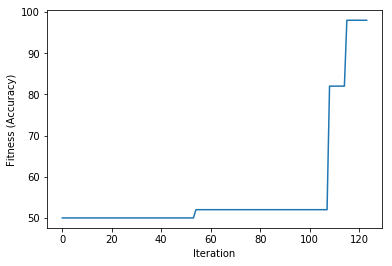

In [22]:
plt.plot(accuracies[:generation])
plt.xlabel("Iteration")
plt.ylabel("Fitness (Accuracy)")
plt.show()

In [24]:
 predictions, Y

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1]))